## Predicting Voting Behavior ##

< TODO: Short Project Description Here >

### Set up ###

In [28]:
# Install missingno and h2o libraries
!python -m pip install missingno
!python -m pip install h2o

# Verify that java is installed (needed for h2o)
!java -version

openjdk version "20.0.1" 2023-04-18
OpenJDK Runtime Environment Homebrew (build 20.0.1)
OpenJDK 64-Bit Server VM Homebrew (build 20.0.1, mixed mode, sharing)


In [29]:
# Import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import chi2_contingency
import h2o

# Settings
pd.set_option('display.max_columns', None)

In [30]:
# Helper functions
def choose_random_color():
    colors = ['b', 'c', 'g', 'm', 'r', 'y', 'pink', 'turquoise', 'navy', 'lime', 'darkcyan', 'firebrick', 'slateblue', 'blueviolet']
    return random.choice(colors)


### Data cleaning and preprocessing ###

In [31]:
# Read in nonvoters dataset
non_voters = pd.read_csv('nonvoters_data.csv')
sample_size = len(non_voters)

# Print data types and non-null count for each feature  
non_voters.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5836 entries, 0 to 5835
Data columns (total 119 columns):
 #    Column          Non-Null Count  Dtype  
---   ------          --------------  -----  
 0    RespId          5836 non-null   int64  
 1    weight          5836 non-null   float64
 2    Q1              5836 non-null   int64  
 3    Q2_1            5836 non-null   int64  
 4    Q2_2            5836 non-null   int64  
 5    Q2_3            5836 non-null   int64  
 6    Q2_4            5836 non-null   int64  
 7    Q2_5            5836 non-null   int64  
 8    Q2_6            5836 non-null   int64  
 9    Q2_7            5836 non-null   int64  
 10   Q2_8            5836 non-null   int64  
 11   Q2_9            5836 non-null   int64  
 12   Q2_10           5836 non-null   int64  
 13   Q3_1            5836 non-null   int64  
 14   Q3_2            5836 non-null   int64  
 15   Q3_3            5836 non-null   int64  
 16   Q3_4            5836 non-null   int64  
 17   Q3_5        

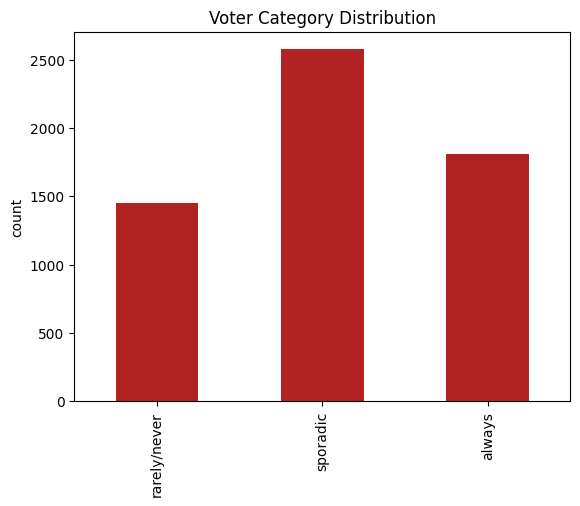

count    5836.000000
mean       51.693797
std        17.071561
min        22.000000
25%        36.000000
50%        54.000000
75%        65.000000
max        94.000000
Name: ppage, dtype: float64


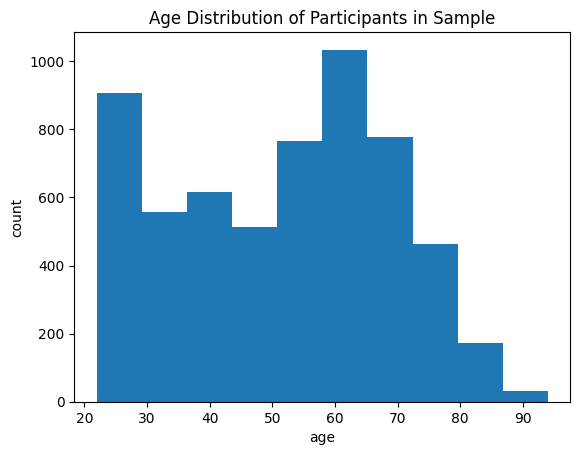

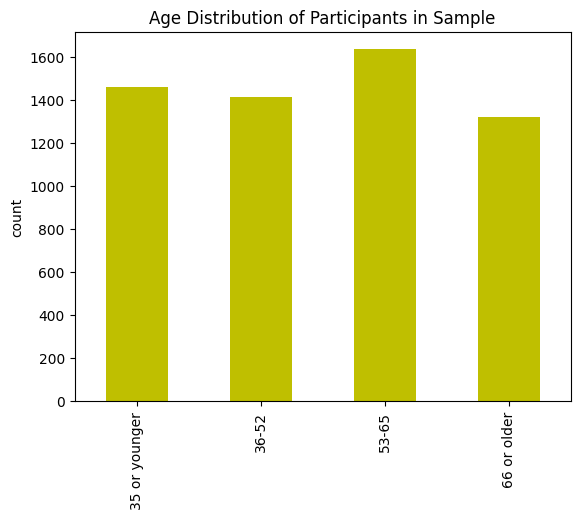

In [32]:
# Change categorical features to be of type category (this is all columns except RespId, weight, and ppage)
non_categorical = ['RespId', 'weight', 'ppage']
for column in non_voters.columns:
    if column not in non_categorical:
        non_voters[column] = non_voters[column].astype('category')

# Introduce ordering to demographic features with inherent ordering
non_voters.income_cat = pd.Categorical(non_voters.income_cat, ordered=True, categories=['Less than $40k', '$40-75k', '$75-125k', '$125k or more'])
non_voters.educ = pd.Categorical(non_voters.educ, ordered=True, categories=['High school or less', 'Some college', 'College'])
non_voters.voter_category = pd.Categorical(non_voters.voter_category, ordered=True, categories=['rarely/never', 'sporadic', 'always'])

# Examine target variable distribution
non_voters.voter_category.value_counts().sort_index().plot(kind='bar', color=choose_random_color())
plt.title('Voter Category Distribution')
plt.ylabel('count')
plt.show()

# Examine age distribution of participants
print(non_voters.ppage.describe())

plt.hist(non_voters.ppage)
plt.title('Age Distribution of Participants in Sample')
plt.xlabel('age')
plt.ylabel('count')
plt.show()
plt.clf()

# Convert age feature to be catgorical instead of quantitative to improve interpretability
non_voters.ppage = pd.cut(non_voters.ppage, bins=[0, 36, 53, 66, 99], labels=['35 or younger', '36-52', '53-65', '66 or older'])
non_voters.ppage = pd.Categorical(non_voters.ppage, ordered=True, categories=['35 or younger', '36-52', '53-65', '66 or older'])

# Examine new distribtuion
non_voters.ppage.value_counts().sort_index().plot(kind='bar', color=choose_random_color())
plt.title('Age Distribution of Participants in Sample')
plt.ylabel('count')
plt.show()

        ppage     educ   race gender income_cat
count    5836     5836   5836   5836       5836
unique      4        3      4      2          4
top     53-65  College  White   Male   $75-125k
freq     1637     2330   3710   2940       1628


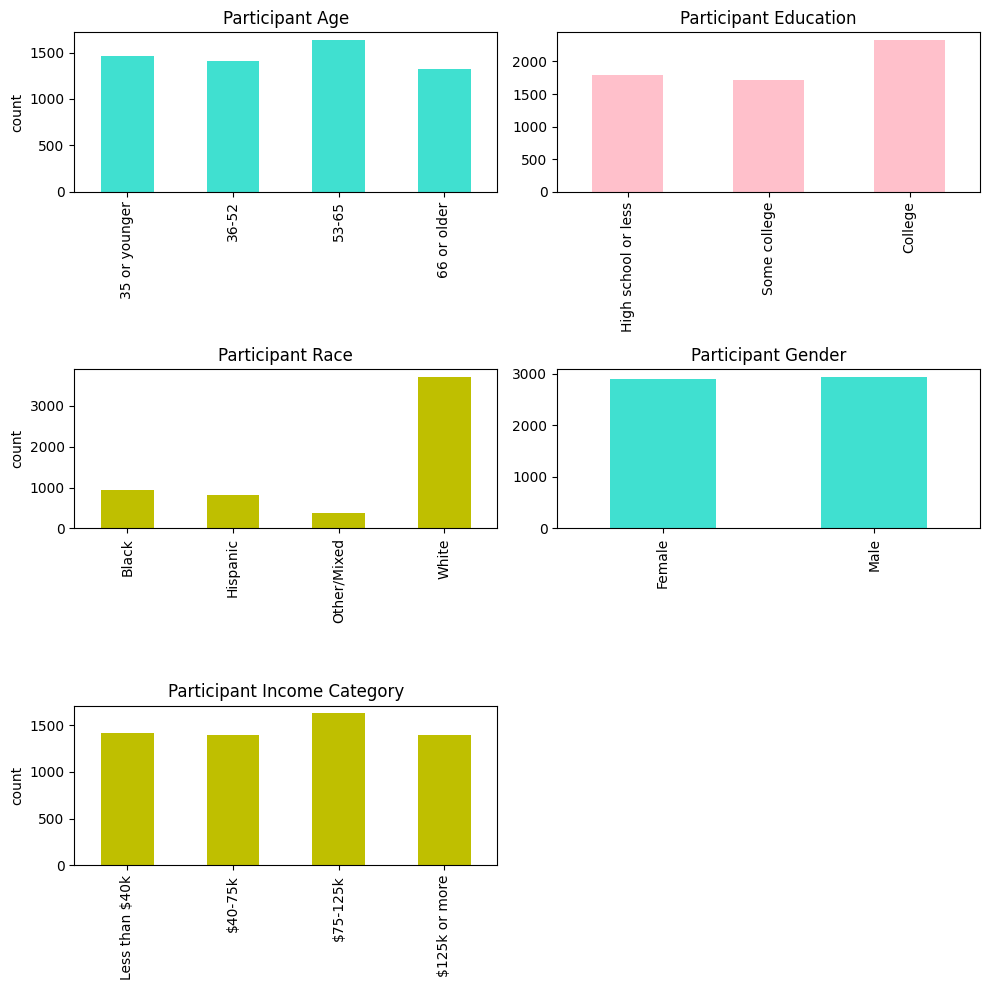

In [33]:
# Examine demographics of participants in the dataset
voter_demographics = non_voters[['ppage', 'educ', 'race', 'gender', 'income_cat']].copy()
print(voter_demographics.describe(include='all'))

# Visualize distribution of participant demographics
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
voter_demographics.ppage.value_counts().sort_index().plot(ax=ax[0, 0], kind='bar', color=choose_random_color())
ax[0, 0].set_title('Participant Age')
ax[0, 0].set_ylabel('count')

voter_demographics.educ.value_counts().sort_index().plot(ax=ax[0, 1], kind='bar', color=choose_random_color())
ax[0, 1].set_title('Participant Education')

voter_demographics.race.value_counts().sort_index().plot(ax=ax[1, 0], kind='bar', color=choose_random_color())
ax[1, 0].set_title('Participant Race')
ax[1, 0].set_ylabel('count')

voter_demographics.gender.value_counts().sort_index().plot(ax=ax[1, 1], kind='bar', color=choose_random_color())
ax[1, 1].set_title('Participant Gender')

voter_demographics.income_cat.value_counts().sort_index().plot(ax=ax[2, 0], kind='bar', color=choose_random_color())
ax[2, 0].set_title('Participant Income Category')
ax[2, 0].set_ylabel('count')

ax[2, 1].axis('off')

plt.tight_layout()
plt.show()
    

In [34]:
# Perform one-hot encoding on race column since it is not binary and not ordinal
non_voters = pd.concat([non_voters, pd.get_dummies(non_voters['race'])], axis=1)
non_voters.drop(columns=['race'], axis=1, inplace=True)

voter_demographics = non_voters[['ppage', 'educ', 'gender', 'income_cat', 'Black', 'Hispanic', 'Other/Mixed', 'White']].copy()

In [35]:
# Remove column for question 1 since every participant answered yes (prerequiste for being included in the sample)
non_voters.drop(f'Q1', axis=1, inplace=True)

# Remove columns for question 19 because it has a different format than the other questions
for i in range(1, 11):
    non_voters.drop(f'Q19_{i}', axis=1, inplace=True)

# Check for NA values
na_feature_count = 0
na_columns = []
for column in non_voters.columns:
    na_values = non_voters[column].isna().sum()
    if(na_values > 0):
        na_columns.append(column)
        na_feature_count += 1

print(f'{na_feature_count} features have NA values.')
print(na_columns)

# Drop all columns with NA values since they represent questions asked to a subset of participants
non_voters.drop(na_columns, axis=1, inplace=True)

22 features have NA values.
['Q22', 'Q28_1', 'Q28_2', 'Q28_3', 'Q28_4', 'Q28_5', 'Q28_6', 'Q28_7', 'Q28_8', 'Q29_1', 'Q29_2', 'Q29_3', 'Q29_4', 'Q29_5', 'Q29_6', 'Q29_7', 'Q29_8', 'Q29_9', 'Q29_10', 'Q31', 'Q32', 'Q33']


In [36]:
# Replace remaining -1 missing values with nan for easier analysis
non_voters = non_voters.replace(-1, np.nan)

# Use a missingno matrix to visually inspect if missing values are MCAR (missing completely at random)
#msno.matrix(non_voters)

# Since the missingness looks like it might not be MCAR, use chi-square tests to check if there is a signigicant relationship 
# between participant demographics and missing values, which could indicate that there is additional information in the missing values
# Chose one variable pair to test
contingency_table = pd.crosstab(non_voters['educ'], non_voters['Q2_1'].isna())
contingency_table = contingency_table.rename(columns={False: "Answered", True: "Did Not Answer"})
print(contingency_table)
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'chi statistic: {chi2}')
print(f'p-value: {p}')

# Test the other variables
questions = non_voters.filter(like='Q')
significant_count = 0
total_relationships = 0
for q in questions.columns:
    for d in voter_demographics.columns:
        total_relationships += 1
        # Create a contingency table
        contingency_table = pd.crosstab(non_voters[d], non_voters[q].isna())

        # Perform chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Set significance level for interpreting p-value
        alpha = 0.05
        if p <= alpha:
            significant_count += 1

if not significant_count:
    print('There was no significant relationship found between demographic variables and missing values.')
else:
    print(f'{significant_count} significant relationships found out of {total_relationships}.')

# Since no significant relationship was found, assume MCAR and perform mode imputation on missing values
# for column in non_voters.columns:
#     if non_voters[column].isna().sum() > 0:
#         non_voters[column].fillna(non_voters[column].mode()[0], inplace=True)


Q2_1                 Answered  Did Not Answer
educ                                         
High school or less      1773              23
Some college             1704               6
College                  2324               6
chi statistic: 20.321547041372234
p-value: 3.865735433536265e-05
185 significant relationships found out of 624.


### Training the model ###

In [37]:
# Initialize the h2o cluster
h2o.init()

# Convert the pandas DataFrame to an h2o Frame
non_voters_h2o = h2o.H2OFrame(non_voters)

# Input parameters that are going to train, use all explanatory variables for first pass
training_columns = [c for c in non_voters.columns if c not in ['RespId', 'weight', 'voter_category']]

# Output parameter train against input parameters
response_column = 'voter_category'

# Split cleaned dataset into training and test sets (80% for training, 20% for testing)
train, test = non_voters_h2o.split_frame(ratios=[0.8], seed=42)

# Check the dimensions of the splits
print("Training set shape:", train.shape)
print("Test set shape:", test.shape)

# Define model
model = h2o.estimators.H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=100)

# Train model
model.train(x=training_columns, y=response_column, training_frame=train, weights_column='weight')

# Model performance
performance = model.model_performance(test_data=test)

print(performance)

#print(model.feature_interaction())

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "20.0.1" 2023-04-18; OpenJDK Runtime Environment Homebrew (build 20.0.1); OpenJDK 64-Bit Server VM Homebrew (build 20.0.1, mixed mode, sharing)
  Starting server from /opt/homebrew/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/8d/zjs9s_1s6njg6wx3_cvk_l5c0000gn/T/tmpgsqf07_a
  JVM stdout: /var/folders/8d/zjs9s_1s6njg6wx3_cvk_l5c0000gn/T/tmpgsqf07_a/h2o_juliet_started_from_python.out
  JVM stderr: /var/folders/8d/zjs9s_1s6njg6wx3_cvk_l5c0000gn/T/tmpgsqf07_a/h2o_juliet_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 23 days
H2O_cluster_name:,H2O_from_python_juliet_d1qfyl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training set shape: (4683, 89)
Test set shape: (1153, 89)
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.2735852638695767
RMSE: 0.5230537867844728
LogLoss: 0.7775910343427375
Mean Per-Class Error: 0.395636727643428
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
always    rarely/never    sporadic    Error     Rate
--------  --------------  ----------  --------  -----------
174       21              163         0.513966  184 / 3

### Feature Selection ###

In [62]:
# Examine feature importance from the first pass model
#print(model.feature_frequencies(test_data=test))

imp = model.varimp()
for feature, imp, scaled_imp, percent in imp:
    print(f'{feature}: {scaled_imp}')


Q26: 1.0
Q27_2: 0.6983910310628865
Q27_6: 0.5990073291263186
ppage: 0.5930616176057922
Q27_4: 0.5170132072382748
Q27_1: 0.512823311053614
Q27_5: 0.4001081309295032
income_cat: 0.27014507802819804
Q27_3: 0.26277637085248656
Q21: 0.22665124881151028
Q15: 0.17682586565037023
educ: 0.17167652381334747
Q14: 0.16513724130221305
Q17_4: 0.1625672342571042
Q30: 0.15812151663630242
Q4_4: 0.15405729676648514
Q2_2: 0.1515098110872365
Q9_2: 0.15075335919471824
Q4_6: 0.1500425529681245
Q4_5: 0.14934926730016845
Q24: 0.148696919091337
Q3_5: 0.14795656022206138
Q3_3: 0.1472495400676024
Q2_10: 0.14535903987054932
Q3_6: 0.14465571712143038
Q8_5: 0.1438764955960267
Q4_3: 0.14065389207506118
Q8_6: 0.13880753907510177
Q2_9: 0.1385336916795931
Q9_3: 0.13791367138411845
Q8_8: 0.13755004885895056
Q6: 0.13707105310048628
Q17_3: 0.13561493153079177
Q3_4: 0.13525889888325235
Q3_2: 0.13507065927805084
Q20: 0.13502800168310855
Q8_2: 0.1342391952771951
Q8_4: 0.13364180274773432
Q4_2: 0.13196940513234617
Q2_4: 0.130

In [53]:
# Conduct Cramer's v test to find explanatory variables with strongest association
cramer_v_values = []
for column in non_voters.columns:
    if column not in ['voter_category', 'RespId', 'weight']:
        contingency_table = pd.crosstab(non_voters[column], non_voters['voter_category'])
        x2 = chi2_contingency(contingency_table)[0]
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramer_v = np.sqrt((x2/n) / min_dim)
        cramer_v_values.append((column, cramer_v))

# Sort the Cramer's V values in descending order
sorted_cramer_v = sorted(cramer_v_values, key=lambda x: x[1], reverse=True)

# Print the sorted Cramer's V values by association level
very_strong = [(k,v) for (k, v) in sorted_cramer_v if v >= 0.5]
moderately_strong = [(k,v) for (k, v) in sorted_cramer_v if v >= 0.3 and v < 0.5]
moderate = [(k,v) for (k, v) in sorted_cramer_v if v >= 0.2 and v < 0.3]
weak = [(k,v) for (k, v) in sorted_cramer_v if v >= 0.1 and v < 0.2]

print('Very Strong Association:')
for feature, value in very_strong:
    print(f'{feature}: {value}')
print('\nModerately Strong Association:')
for feature, value in moderately_strong:
    print(f'{feature}: {value}')
print('\nModerate Association:')
for feature, value in moderate:
    print(f'{feature}: {value}')
print('\nWeak Association:')
for feature, value in weak:
    print(f'{feature}: {value}')


Very Strong Association:
Q27_2: 0.6243952642015779
Q27_4: 0.5913994693428056
Q27_1: 0.5451781739990903
Q27_6: 0.5408805486855754
Q27_3: 0.52899786208004
Q27_5: 0.5123257155625766

Moderately Strong Association:
Q20: 0.4928292813942399
Q26: 0.4864294241599487
Q21: 0.34683232961966376
Q2_1: 0.3073270234190789

Moderate Association:
ppage: 0.2724551150405875
Q5: 0.2477988508228831
Q25: 0.24500093224334418

Weak Association:
Q2_3: 0.1975317032370354
Q2_2: 0.19639611018438957
Q30: 0.18631248338452275
Q2_5: 0.17077878562055976
Q9_1: 0.1677326348608688
Q6: 0.1625454285146432
Q16: 0.1571410788092562
Q11_5: 0.1557695988532879
Q23: 0.14980174095405885
Q18_3: 0.13867352645505174
Q17_1: 0.13503926880751085
Q17_2: 0.1336448209672957
Q4_2: 0.1333836618058866
income_cat: 0.13035475321196904
Q9_4: 0.12701195612654206
educ: 0.12485365762440266
Q2_7: 0.1225384752304419
Q8_5: 0.12106960750901047
Q4_1: 0.11970217993840894
Q9_3: 0.11802905691621197
Q15: 0.11553822022022474
Q14: 0.1126672736966061
Q24: 0.11

In [64]:
# Run model again with reduced feature set
model = h2o.estimators.H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=100)

# Train model
very_strong_features = [k for k, _ in very_strong]
moderately_strong_features = [k for k, _ in moderately_strong]
moderate_features = [k for k, _ in moderate]
training_columns = very_strong_features + moderately_strong_features + moderate_features
print(training_columns)

model.train(x=training_columns, y=response_column, training_frame=train, weights_column='weight')

# Model performance
performance = model.model_performance(test_data=test)

print(performance)

['Q27_2', 'Q27_4', 'Q27_1', 'Q27_6', 'Q27_3', 'Q27_5', 'Q20', 'Q26', 'Q21', 'Q2_1', 'ppage', 'Q5', 'Q25']
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.27836768936583195
RMSE: 0.5276056191568016
LogLoss: 0.9343863168462127
Mean Per-Class Error: 0.41353456119718573
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
always    rarely/never    sporadic    Error     Rate
--------  --------------  ----------  --------  -----------
192       23              143         0.463687  166 / 358
43        184             71          0.3